# Cocktail Recipe Network Analysis
## Introduction
One of my friends recently acquired a [poster](https://www.amazon.com/100-Cocktails-Scratch-Bucket-Poster/dp/B079NQXDX2) of 100 cocktails and the immediate question is where to start and how to proceed. Well, clearly it's easiest to move between recipes that share many ingredients. One way to visualize all of these interactions is using a network. A network in this conext is a collection of nodes (cocktails) connected by edges. Not all pairs of nodes need have edges. In this case, edges exist between two cocktails if they share any ingredients. Furthermore, we can weight these edges according to how many ingredients they share.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from fa2 import ForceAtlas2

import graspy
from graspy import embed
from graspy import plot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

### Load Data

In a csv file, all 100 of the drinks were entered along with their alcholic and non-alcoholic ingredients.

In [3]:
path = './recipes.csv'
with open('./.plotly_key.cred') as f:
    plotly_user,plotly_key = [l.strip().split('=')[1] for l in f.readlines()]
data = pd.read_csv(path, sep=',', encoding = "utf-8")

In [4]:
nodes = data.Name.values
alcohols = [[w.lower() for w in v.split('; ')] if type(v) == str else [v] for v in data.Alcohol.values]
ingredients = [[w.lower() for w in v.split('; ')] if type(v) == str else [''] for v in data.Ingredients.values]
ingredients_total = [i + j if not j == [''] else i for i,j in zip(alcohols, ingredients)]

### Initial Ingredient Network and Plots

Once we load all of the data, we can easily make a network composed of nodes (cocktails) connected by edges with weight proportional to the number of shared ingredients. An easy network to construct is a simple undirected graph whre each edge weight is the number of shared ingredients. One issue is that such edges are symmetric and thus the ease of going from cocktail $A \rightarrow B$ is the same as the ease of $B \rightarrow A$. This is not necessarily true, as in the case where cocktail A has many more ingredients total. So, we use instead a directed graph with the edge weight of $A \rightarrow B$ being the fraction

$\frac{\text{Shared Ingredients} + \text{A Ingredients}}{\text{A Ingredients + B Ingredients}}$ 

Because the alcoholic ingredients are more pricey and harder to come by, this fraction was calculated separately for each set and the alcoholic fraction was weighted an order of magnitude greater before the two were summed.

In [39]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
for n,a,i in zip(nodes,alcohols,ingredients):
    G.nodes[n]['Alcohols'] = a
    G.nodes[n]['Ingredients'] = i
    
for n1,a1,i1 in zip(nodes,alcohols,ingredients):
    for n2,a2,i2 in zip(nodes,alcohols,ingredients):
        if n1 == n2:
            continue
        mutual_alc = (len(a1) + len(set(a1) & set(a2))) / (len(a2) + len(a1))
        mutual_ing = (len(i1) + len(set(i1) & set(i2))) / (len(i2) + len(i1))
        if 10*len(set(a1) & set(a2)) + len(set(i1) & set(i2)) == 0:
            continue
        G.add_edge(n1,n2,weight=10*mutual_alc + 1*mutual_ing,major=(len(set(a1) & set(a2)) > 0))

Now we draw our network...

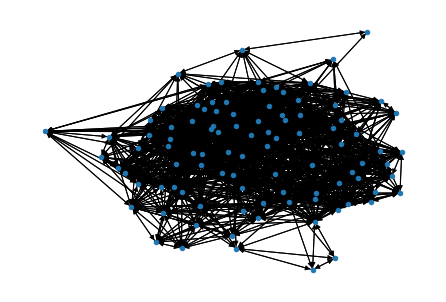

In [21]:
nx.draw_kamada_kawai(G,node_size=20)

...but this makes no discernable sense to us and provides little meaningful information as it is too cluttered. To imporve our visualization, we use the ForceAtlas2 package and its simulated forces based on edge weights to create a more meaningful visualization.

In [22]:
forceatlas2 = ForceAtlas2(scalingRatio=1,
                          strongGravityMode=False,
                          gravity=30)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 542.57it/s]


BarnesHut Approximation  took  0.63  seconds
Repulsion forces  took  2.41  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.24  seconds


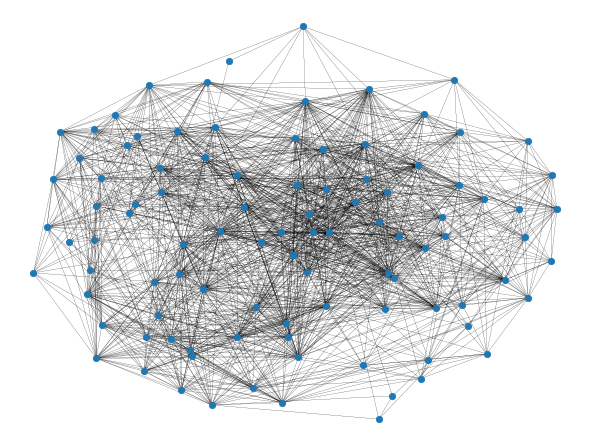

In [23]:
## Plot the new graph
plt.figure(figsize=(8,6))
nx.draw(G ,pos,node_size=40,width=0.1, linewidths=0.8, zoom=1.5, arrows=False)
plt.show()

### Community Detection

The ForceAtlas2 visualization looks nice, but what we want to know is what communities exist within the graph, and thus what cocktails are easy to transition between. A community is a set of nodes which are more strongly connected with each other than nodes among other communities, and hence have more ingredients in common.

A graph is just as nicely represented by an adjacency matrix. For a graph of $n$ nodes, in our case 100, the adjacency matrix is an $n \times n$ matrix where the index $i,j$ is the strength of the connection from node $i$ to node $j$. We can visualize this matrix using teh graph statistics package GrasPY.

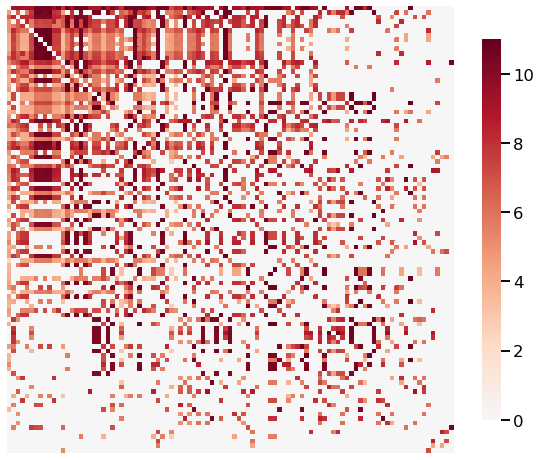

In [24]:
A = nx.to_numpy_matrix(G)
graspy.plot.heatmap(A)
plt.show()

But how do we translate these to community assignments? The answer lies in spectral embedding. We shall reduce the dimensionality of our data, projecting it to a lower dimensional subspace where it bext maximizes the variance.

In [25]:
from sklearn.cluster import KMeans

In [26]:
A = nx.to_numpy_matrix(G)
ase = embed.AdjacencySpectralEmbed()
Xhat = ase.fit_transform(A)[0]

Now, we can us a K-means clustering algorithm to detect communities among nodes. In the below plot, the data has been projected form $n$ dimensions to 4. In this 4-dimensional subspace, K-means has determined and labeled 8 different communities among our data. Once can fairly easily eyeball some of these communities in some of the subspace planes.

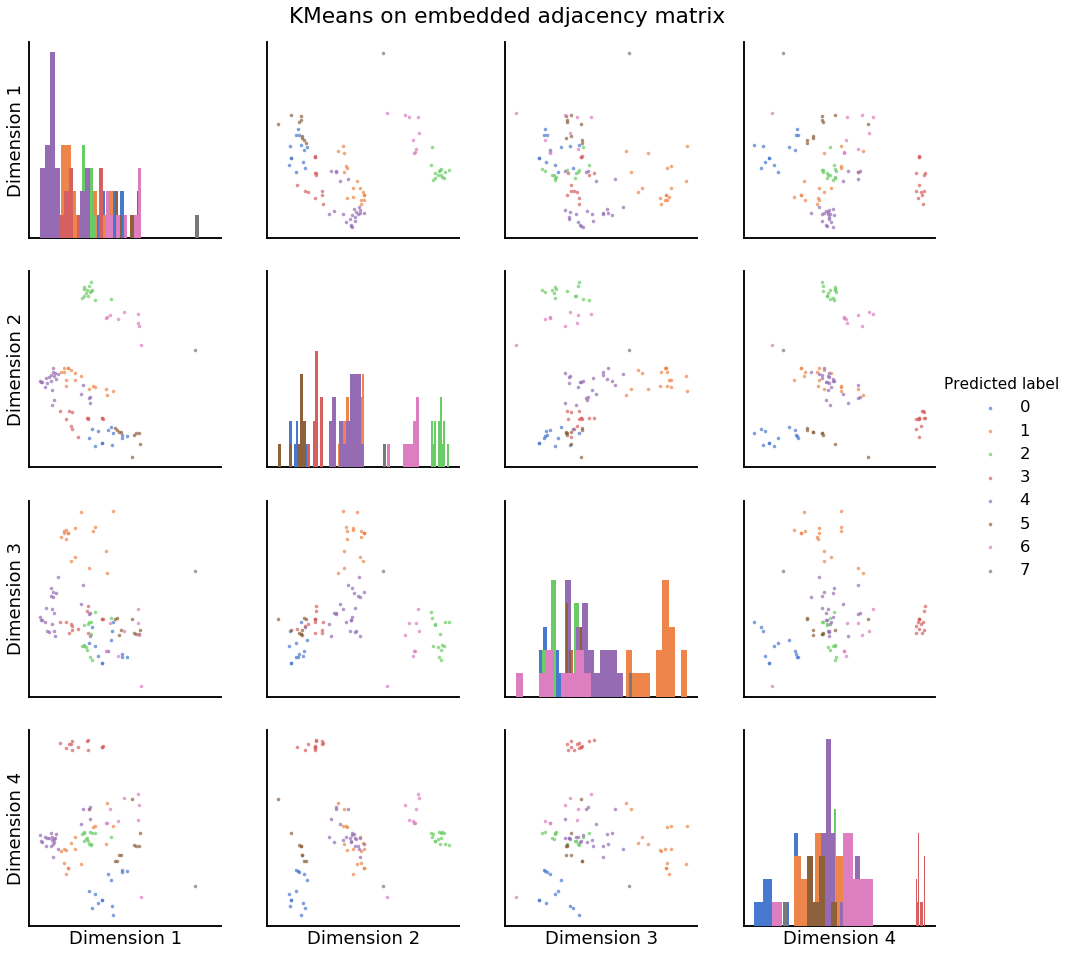

In [27]:
labels_kmeans = KMeans().fit_predict(Xhat)
plot.pairplot(Xhat,
         labels=labels_kmeans,
         title='KMeans on embedded adjacency matrix',
         legend_name='Predicted label',
         height=3.5,
         palette='muted')

In [28]:
idxs = np.argsort(labels_kmeans)
A = A[idxs,:][:,idxs]

We can sort the data according to labels and re-visualize it as a labeled heatmap. As well as plot our graph again, this time with colors.

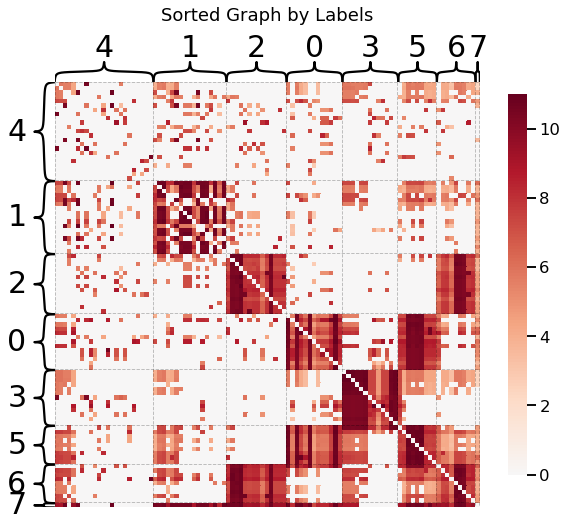

In [29]:
title = 'Sorted Graph by Labels'
fig = plot.heatmap(A, title=title, inner_hier_labels=labels_kmeans[idxs])

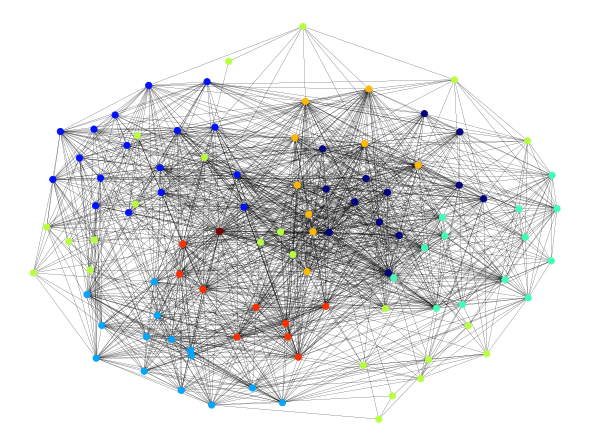

In [30]:
plt.figure(figsize=(8,6))
nx.draw(G ,pos,node_size=40,width=0.1, linewidths=0.8, zoom=1.5,node_color=labels_kmeans+1,cmap=plt.cm.jet, arrows=False)
#plt.gca().collections[0].set_edgecolor("#000000") 
#plt.savefig('./network.png',bbox_inches='tight')
plt.show()

The results are intriguing. Notably, we have some very strong blocks present along the diagonal of the heatmap. This means very highly connected subsets of nodes in our graph. But what are these subsets. Looking over the nodes within each subset and their recipes, we can see how different communities are characterized by their ingredients.

In [31]:
terms = {i:[] for i in range(max(labels_kmeans) + 1)}
counts = {i:0 for i in range(max(labels_kmeans) + 1)}
for label,alc in zip(labels_kmeans, alcohols):
    terms[label] += alc
    counts[label] += 1

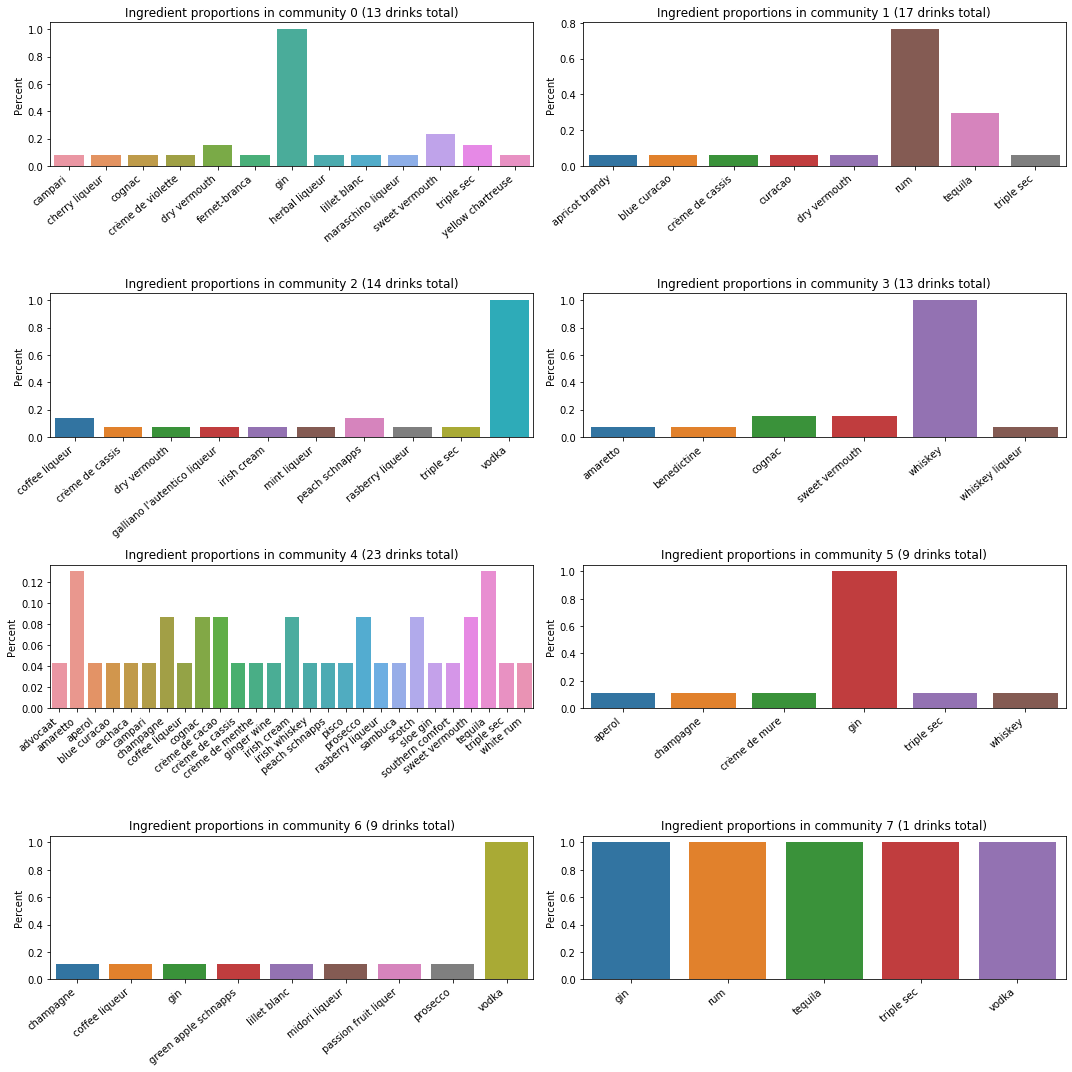

In [32]:
plt.figure(figsize=(15,15))
for i in range(max(labels_kmeans) + 1):
    plt.subplot(4,2,i+1)
    keys, counts2 = np.unique(terms[i],return_counts=True)
    ax = sns.barplot(x=keys, y=counts2/counts[i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.ylabel('Percent')
    plt.title('Ingredient proportions in community %d (%d drinks total)' % (i, counts[i]))
plt.tight_layout()
plt.show()

Most communities seem to be highly characterized by a single liquor. Community 6 is a single drink, the highly connected Long Island Iced Tea. Community 0 is also fairly unique and appears to be a wide variety of fringe beverages not strongly connected to the core of the graph, ie. the Grasshopper.

### Interactive Plots

Putting it all together, we are interested in visualizing this network and the communities interactively so that we can investigate and explore further. All the low weight edges clutter the graph and so we threshold the graph to make it more readable.

In [33]:
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
import matplotlib as mpl

from tqdm import tqdm
import pickle

In [34]:
plotly.tools.set_credentials_file(username=plotly_user, api_key=plotly_key)

In [47]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.15,color='#888'),
    hoverinfo='none',
    mode='lines')


weights = []
for edge in tqdm(G.edges(data=True)):
    if edge[2]['major'] == False:
        continue
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

100%|██████████████████████████████████████████████████████████████████████████████| 3156/3156 [10:15<00:00,  1.80it/s]


In [48]:
#pickle.dump(edge_trace, open('./edge_trace.pkl','wb'))

In [124]:
edge_trace = pickle.load(open('./edge_trace.pkl','rb'))

In [103]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='Jet',
        reversescale=False,
        color=[],
        size=10,
        line=dict(width=2)))

In [104]:
for node in tqdm(G.nodes()):
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 112.96it/s]


In [105]:
for i, adjacencies in tqdm(enumerate(G.adjacency())):
    cols = cmap(labels_kmeans[i])[:3]
    cols = [255*j for j in cols]
    node_trace['marker']['color']+=tuple([labels_kmeans[i]]) #tuple("rgb(%d, %d, %d)" % (1,2,3))
    node_info = 'Name: %r <br> Alcohols: %r <br> Ingredients: %r <br> Community %r' % (nodes[i],alcohols[i],ingredients[i],labels_kmeans[i])
    node_trace['text']+=tuple([node_info])

99it [00:00, 124.99it/s]


In [106]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Cocktail Recipe Network with Community Labels',
                titlefont=dict(size=24),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='recipe_network')